In [1]:
from operator import concat
import kagglehub
import kagglehub.config
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
from sentry_sdk.utils import epoch

import wandb
import pytorch_lightning.loggers as wandb_logger
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50
from RoadDataLoader import RoadDataLoader

In [2]:
# get kaggle.json file form ./kaggle.json
with open("./kaggle.json", "r") as f:
    kaggle_json = json.load(f)
kaggel_username = kaggle_json["username"]
kaggel_key = kaggle_json["key"]

In [3]:
kagglehub.config.set_kaggle_credentials(kaggel_username, kaggel_key)

Kaggle credentials set.


In [ ]:
# Download latest version
path = kagglehub.dataset_download("payne18/road-detection-dataset-with-masks")
#make data folder if not existing
if not os.path.exists("./data"):
    os.mkdir("./data")
# Move data folder to ./data
os.system(f"mv {path} ./data/road-detection-dataset-with-masks")
# remove empty folder
folder_to_remove = path.split("payne18/road-detection-dataset-with-masks")[0] 
os.system((f"rm -r {folder_to_remove}"))

# Lightining module

In [2]:
class RoadSegmentationModule(pl.LightningModule):
    def __init__(self, model, loss_fn, accuracy_fn, optimizer, only_last_layer=False, weight_decay=0.01, lr=1e-3):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.accuracy_fn = accuracy_fn
        self.optimizer = optimizer
        self.lr = lr
        self.only_last_layer = only_last_layer
        self.weight_decay = weight_decay
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        if y.shape != pred.shape:
            pred = pred.squeeze(1)
        loss = self.loss_fn(pred, y)
        acc = self.accuracy_fn(pred, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        if y.shape != pred.shape:
            pred = pred.squeeze(1)
        loss = self.loss_fn(pred, y)
        acc = self.accuracy_fn(pred, y)
        
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def configure_optimizers(self):
        if self.optimizer == "Adam":
            if self.only_last_layer:
                opt = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr)
            else:
                opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optimizer == "AdamW":
            if self.only_last_layer:
                opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr, weight_decay=self.weight_decay)
            else:
                opt = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError("Optimizer not implemented in RoadSegmentationModule")
        return opt


# Baseline models

In [3]:
class DeepLabV3Model(torch.nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.model = deeplabv3_resnet50(pretrained=pretrained)
        
        self.model.classifier[4] = nn.Conv2d(
            in_channels=self.model.classifier[4].in_channels,
            out_channels=1,
            kernel_size=self.model.classifier[4].kernel_size,
            stride=self.model.classifier[4].stride,
            padding=self.model.classifier[4].padding
        )
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad = False
            
            # Csak az utolsó réteg paramétereinek engedélyezése a tanításra
            for param in self.model.classifier[4].parameters():
                param.requires_grad = True
        
    def forward(self, x):
        return self.model(x)["out"]

In [4]:
class FCNR50Model(torch.nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.model = fcn_resnet50(pretrained=pretrained)
        
        self.model.classifier[4] = nn.Conv2d(
            in_channels=self.model.classifier[4].in_channels,
            out_channels=1,
            kernel_size=self.model.classifier[4].kernel_size,
            stride=self.model.classifier[4].stride,
            padding=self.model.classifier[4].padding
        )
        
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad = False
            
           
            for param in self.model.classifier[4].parameters():
                param.requires_grad = True
        
        
    def forward(self, x):
        return self.model(x)["out"]

In [5]:
class UNET2D(nn.Module):
    def __init__(self, in_channels, out_channels, chanel_list=[8, 16, 32, 64]):
        super(UNET2D, self).__init__()
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.in_channels = in_channels
        self.out_channels = out_channels

        for out_channel in chanel_list:
            self.down_blocks.append(
                nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channel, 3, padding=1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU(),
                    nn.Conv2d(out_channel, out_channel, 3, padding=1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU()
                )
            )
            self.in_channels = out_channel

        for out_channel in reversed(chanel_list):
            self.up_blocks.append(
                nn.ConvTranspose2d(out_channel * 2, out_channel, 2, 2)
            )
            self.up_blocks.append(
                nn.Sequential(
                    nn.Conv2d(out_channel * 2, out_channel, 3, padding=1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU(),
                    nn.Conv2d(out_channel, out_channel, 3, padding=1),
                    nn.BatchNorm2d(out_channel),
                    nn.ReLU()
                )
            )
            self.in_channels = out_channel

            self.bottleneck = nn.Sequential(
                nn.Conv2d(chanel_list[-1], chanel_list[-1]*2, 3, padding=1),
                nn.BatchNorm2d(chanel_list[-1]*2),
                nn.ReLU(),
                nn.Conv2d(chanel_list[-1]*2, chanel_list[-1]*2, 3, padding=1),
                nn.BatchNorm2d(chanel_list[-1]*2),
                nn.ReLU()
            )

            self.final_block = nn.Conv2d(chanel_list[0], out_channels, 1)

    def forward(self, x):
        skip_connections = []
        for block in self.down_blocks:
            x = block(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(2, 2)(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]


        for idx in range(0, len(self.up_blocks), 2):
            x = self.up_blocks[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:], mode='bilinear')

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.up_blocks[idx + 1](concat_skip)

        return self.final_block(x)

# LOAD DATA

In [6]:
data_path = os.path.abspath("./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset")
metadata_path = "./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/metadata.csv"

In [7]:
#open metadata
metadata = pd.read_csv(metadata_path)
print(f"All data: {metadata.shape[0]}")

All data: 8570


In [8]:
metadata = metadata[metadata["split"] == "train"]
print(f"Data withouth validation and test: {metadata.shape[0]}")
metadata["sat_image_path"] = metadata["sat_image_path"].apply(lambda x: os.path.join(data_path, x))
metadata["mask_path"] = metadata["mask_path"].apply(lambda x: os.path.join(data_path, x))
metadata.head()

Data withouth validation and test: 6226


,image_id,split,sat_image_path,mask_path
0,100034,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...
1,100081,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...
2,100129,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...
3,100703,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...
4,100712,train,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...,/Users/panczelbence/Documents/egyetem/MSc/2_Fe...


# Training

In [9]:
# hyperparameters
batch_size = 4
optimizer = "Adam"
lr = 1e-3
weight_decay = 0.01
epochs = 3
loss_fn = nn.BCEWithLogitsLoss()
accuracy_fn = torchmetrics.Accuracy(task="binary")
accelerator = "auto"
pretrained = True
image_size = 256
num_workers = 1

In [10]:
dataLoader = RoadDataLoader(metadata, batch_size=batch_size, image_size=image_size, num_workers=num_workers)
dataLoader.setup()

In [11]:
train_data_loader = dataLoader.train_dataloader()
val_data_loader = dataLoader.val_dataloader()

In [12]:
for batch in train_data_loader:
    x, y = batch
    break

# Trainig with DeepLabV3Model

In [15]:
wandb.login()
model = DeepLabV3Model(pretrained=pretrained)
module = RoadSegmentationModule(model, loss_fn, accuracy_fn, optimizer, only_last_layer=pretrained)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="DeepLabV3Model")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: panczebence (panczebence-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU avai

In [16]:
trainer.fit(module, train_data_loader, val_data_loader)



  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | DeepLabV3Model    | 42.0 M | train
1 | loss_fn     | BCEWithLogitsLoss | 0      | train
2 | accuracy_fn | BinaryAccuracy    | 0      | train
----------------------------------------------------------
257       Trainable params
42.0 M    Non-trainable params
42.0 M    Total params
167.996   Total estimated model params size (MB)
192       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [17]:
wandb.finish()
depplabv3_model_path = checkpoint_callback.best_model_path
print(depplabv3_model_path)
#save path to depplabv3_model_path.txt
with open("depplabv3_model_path.txt", "w") as f:
    f.write(depplabv3_model_path)

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc_epoch,▁
train_acc_step,▄▄█▆▇▆▇▇█▆▇▇▄▅▄▇██▄▄▇▁
train_loss_epoch,▁
train_loss_step,▄▅▁▃▂▃▂▂▁▃▂▁▄▄▅▂▁▁▄▄▂█
trainer/global_step,▄▅▆▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃█
val_acc_epoch,▁
val_acc_step,▂▆█▅▇▃▆▇▃▇▁▅▃█▆▁▅▅▅▇▆▃▅▅▄▅▆█▆▂▄▇▇▃▆▂▃▆▇▇
val_loss_epoch,▁
val_loss_step,▄▄▂▂▄▅▄▁▃▇▄▃█▁▄▃▂▃▁▂▆▅▂▃▃▆▄▃▂▂▄▂▂▃▇▁▂▆▄▃
epoch,0


./road-segmentation/n2mtp1jz/checkpoints/epoch=0-step=1121.ckpt


# Trainig with FCNR50Model

In [18]:
wandb.login()
model = FCNR50Model(pretrained=pretrained)
module = RoadSegmentationModule(model, loss_fn, accuracy_fn, optimizer, only_last_layer=pretrained)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="FCNR50Model")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(module, train_data_loader, val_data_loader)


  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | FCNR50Model       | 35.3 M | train
1 | loss_fn     | BCEWithLogitsLoss | 0      | train
2 | accuracy_fn | BinaryAccuracy    | 0      | train
----------------------------------------------------------
513       Trainable params
35.3 M    Non-trainable params
35.3 M    Total params
141.248   Total estimated model params size (MB)
165       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [20]:
wandb.finish()
fcnr50_model_path = checkpoint_callback.best_model_path
print(fcnr50_model_path)
#save path to fcnr50_model_path.txt
with open("fcnr50_model_path.txt", "w") as f:
    f.write(fcnr50_model_path)

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc_epoch,▁
train_acc_step,▇▂▇▃▅▄▆▆▅█▁▄▆▂▆▄█▇▃▇▆▇
train_loss_epoch,▁
train_loss_step,▂▇▂▆▄▆▃▃▄▁█▅▃▇▂▄▁▂▆▂▃▂
trainer/global_step,▂▄▇▇█▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃
val_acc_epoch,▁
val_acc_step,▆▇▇█▅▆█▆▃▆▆▆▆▆▅▃▇▇▂▄▁▆▇▇▅▆▇▅▇▅▇▆▅▆▃▇▅▇▇▇
val_loss_epoch,▁
val_loss_step,▄▄▃▁▄▄▂▄▄▇▂▄▅▄██▁▄▁▁▄▄▆▄▂▇▂▄▅▅▆▄▅▃▂▆▅▆▅▃
epoch,0


./road-segmentation/m8iio0gv/checkpoints/epoch=0-step=1121.ckpt


# Trainig with UNET2D

In [63]:
wandb.login()
model = UNET2D(3, 1)
module = RoadSegmentationModule(model, loss_fn, accuracy_fn, optimizer, only_last_layer=False)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="UNET2D")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [64]:
trainer.fit(module, train_data_loader, val_data_loader)


  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | UNET2D            | 487 K  | train
1 | loss_fn     | BCEWithLogitsLoss | 0      | eval 
2 | accuracy_fn | BinaryAccuracy    | 0      | eval 
----------------------------------------------------------
487 K     Trainable params
0         Non-trainable params
487 K     Total params
1.949     Total estimated model params size (MB)
71        Modules in train mode
2         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/panczelbence/miniconda3/envs/melytanusla_hf/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [23]:
wandb.finish()
unet2d_model_path = checkpoint_callback.best_model_path
print(unet2d_model_path)
#save path to unet2d_model_path.txt
with open("unet2d_model_path.txt", "w") as f:
    f.write(unet2d_model_path)

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc_epoch,▁
train_acc_step,▁▆▅▇█▆▅▇▇███▆▇▆█▆▇▆▂▅▇
train_loss_epoch,▁
train_loss_step,█▆▅▄▃▃▃▂▂▁▁▁▂▂▂▁▂▂▂▅▂▂
trainer/global_step,▂▇█▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇█
val_acc_epoch,▁
val_acc_step,▆▅▇▆▆▄▇█▄█▆▆▅▅▅▃▅▁▃▃▅▆▆▄▇█▇▆▅▇▅▅█▆▇█▄▂▆█
val_loss_epoch,▁
val_loss_step,▄▃▃▃▄▃▃▆▂▁▄▅▄█▆▂▃▂▂▁▁▆▃▄▃▅▅▅▃▅▅▂▃▃▅▃▃▅▂▂
epoch,0


./road-segmentation/jbb7l93l/checkpoints/epoch=0-step=1121.ckpt


# Testing models

In [24]:
deeplabv3_model_path = ""
fcnr50_model_path = ""
unet2d_model_path = ""
with open("depplabv3_model_path.txt", "r") as f:
    deeplabv3_model_path = f.read()
with open("fcnr50_model_path.txt", "r") as f:
    fcnr50_model_path = f.read()
with open("unet2d_model_path.txt", "r") as f:
    unet2d_model_path = f.read()
    
print(deeplabv3_model_path)
print(fcnr50_model_path)
print(unet2d_model_path)

./road-segmentation/n2mtp1jz/checkpoints/epoch=0-step=1121.ckpt
./road-segmentation/m8iio0gv/checkpoints/epoch=0-step=1121.ckpt
./road-segmentation/jbb7l93l/checkpoints/epoch=0-step=1121.ckpt


In [48]:
deeplabv3_state_dict = torch.load(deeplabv3_model_path)["state_dict"]
deeplabv3_state_dict = {k.replace("model.model.", "model."): v for k, v in deeplabv3_state_dict.items()}
deeplabv3_model = DeepLabV3Model(pretrained=False)
deeplabv3_model.load_state_dict(deeplabv3_state_dict, strict=False)
deeplabv3_module = RoadSegmentationModule(deeplabv3_model, loss_fn, accuracy_fn, optimizer, only_last_layer=True)

/var/folders/xc/64736sp157z3h17g4gj8t8jr0000gn/T/ipykernel_14876/3952504420.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeplabv3_state_dict = torch.load(deeplabv3_m

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [25.0..507.0].


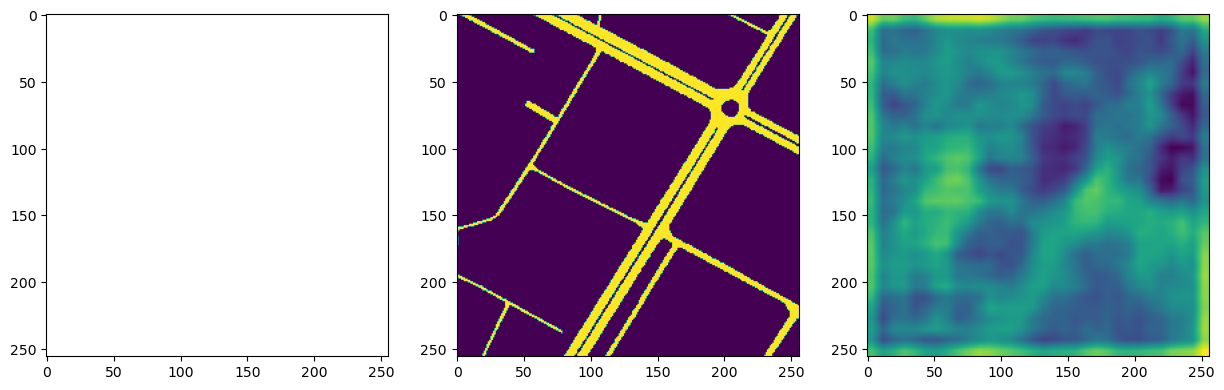

In [51]:
deeplabv3_module.eval()

for batch in val_data_loader:
    x, y = batch
    pred = deeplabv3_module(x)
    break

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(x[1].permute(1, 2, 0))
ax[1].imshow(y[1].squeeze(0))
ax[2].imshow(pred[1].squeeze(0).detach().numpy())
plt.show()

In [60]:
fcnr50_state_dict = torch.load(fcnr50_model_path)["state_dict"]
fcnr50_model = FCNR50Model(pretrained=False)
fcnr50_model.load_state_dict(fcnr50_state_dict, strict=False)
fcnr50_module = RoadSegmentationModule(fcnr50_model, loss_fn, accuracy_fn, optimizer, only_last_layer=False)

/var/folders/xc/64736sp157z3h17g4gj8t8jr0000gn/T/ipykernel_14876/3983033826.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fcnr50_state_dict = torch.load(fcnr50_model_p

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [59.0..495.0].


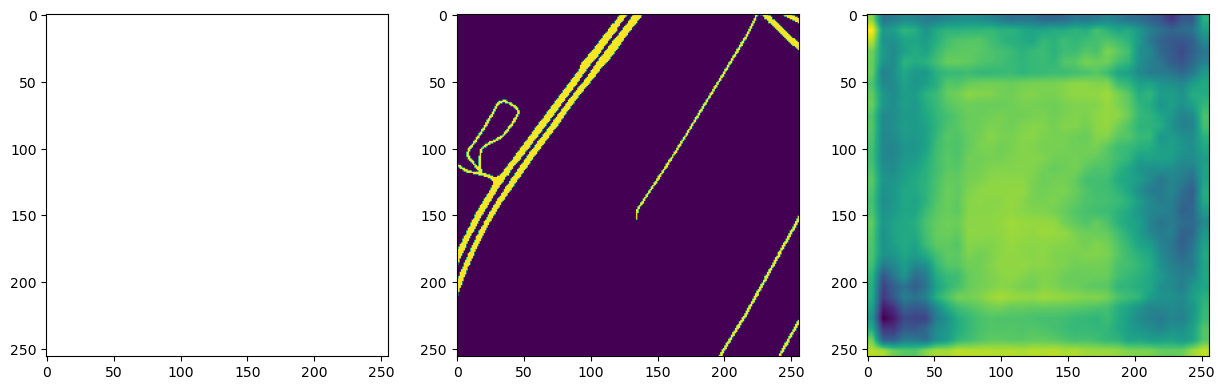

In [62]:
fcnr50_module.eval()

for batch in val_data_loader:
    x, y = batch
    pred = fcnr50_module(x)
    break

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(x[0].permute(1, 2, 0))
ax[1].imshow(y[0].squeeze(0))
ax[2].imshow(pred[0].squeeze(0).detach().numpy())
plt.show()

In [52]:
unet2d_state_dict = torch.load(unet2d_model_path)["state_dict"]
unet2d_model = UNET2D(3, 1)
unet2d_model.load_state_dict(unet2d_state_dict, strict=False)
unet2d_module = RoadSegmentationModule(unet2d_model, loss_fn, accuracy_fn, optimizer, only_last_layer=False)


/var/folders/xc/64736sp157z3h17g4gj8t8jr0000gn/T/ipykernel_14876/2179569821.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet2d_state_dict = torch.load(unet2d_model_p

In [66]:
unet2d_module.eval()

for batch in val_data_loader:
    x, y = batch
    pred = unet2d_module(x)
    break

pred = torch.sigmoid(pred)
pred = (pred > 0.6).float()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(x[2].permute(1, 2, 0))
ax[1].imshow(y[2].squeeze(0))
ax[2].imshow(pred[2].squeeze(0).detach().numpy())
plt.show()

RuntimeError: DataLoader worker (pid(s) 16216) exited unexpectedly